In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
from ChildProject.projects import ChildProject
from ChildProject.annotations import AnnotationManager

DATA_PATH = Path('/home/engaclew/neurogen')
columns = ['recording_filename', '5s_CTC', 'voc_chi', 'voc_dur_chi']

# Read measures
aclew_measures = pd.read_csv(DATA_PATH / 'aclew_measures_chunks.csv').fillna(0)
lena_measures = pd.read_csv(DATA_PATH / 'lena_measures_chunks.csv').fillna(0)
human_measures = pd.read_csv(DATA_PATH / 'human_measures_chunks.csv').fillna(0)

# Read metadata
children = pd.read_csv(DATA_PATH / 'data/L3_HIPAA_LENA_cleaned/metadata/children.csv')
recordings = pd.read_csv(DATA_PATH / 'data/L3_HIPAA_LENA_cleaned/metadata/recordings.csv')
recordings_data = recordings.merge(children, on='child_id')[['group_id', 'recording_filename']]
aclew_measures = aclew_measures.merge(recordings_data, how='left', on='recording_filename')
lena_measures = lena_measures.merge(recordings_data, how='left', on='recording_filename')
human_measures = human_measures.merge(recordings_data, how='left', on='recording_filename')

def compute_CVC(data):
    if 'can_voc_CHI' in data.columns and 'non_can_voc_CHI' in data.columns:
        data['CVC'] = data['can_voc_CHI'] + data['non_can_voc_CHI']
    return data

aclew_measures = compute_CVC(aclew_measures)
human_measures = compute_CVC(human_measures)
print(len(human_measures))
# LENA already has CVC

750


In [2]:
from scipy import stats

def compute_pearson(x, y):
    """ Compute Pearson correlation coefficient """
    r, _ = stats.pearsonr(x, y)
    return r

def compute_group_pearson(x, y, groups):
    out = {}
    for group in np.unique(groups):
        mask = groups == group
        x_group = x[mask]
        y_group = y[mask]
        r, _ = stats.pearsonr(x_group, y_group)
        out[group] = r
    return out
    
def compute_me(x, y):
    """ Compute mean error """
    me_list = (x-y).values
    return me_list

def compute_mpe(x, y):
    """ Compute mean error """
    errors = np.zeros_like(x, dtype=float)
    # Case 1: y != 0 - standard MPE calculation
    mask_nonzero = (y != 0)
    errors[mask_nonzero] = (x[mask_nonzero] - y[mask_nonzero]) / y[mask_nonzero]
    # Case 2: y = 0 and x != 0 -> error = 1
    mask_zero_error = (y == 0) & (x != 0)
    errors[mask_zero_error] = 1
    # Case 3: y = 0 and x = 0 -> error = 0 is already handled by initialization
    return 100*errors


columns = ['group_id', '5s_CTC', 'voc_dur_chi', 'voc_chi', 'wc_adu', 'CVC']
lena_scores, aclew_scores = {}, {}
print("Computing on %d chunks." % len(human_measures))
for col in columns:
    if col == 'group_id':
        lena_scores[col] = lena_measures[col].values
        aclew_scores[col] = aclew_measures[col].values
        continue
        
    if col == 'voc_dur_chi':
        lena_measures[col] /= 1000
        aclew_measures[col] /= 1000
        human_measures[col] /= 1000

    groups =  human_measures['group_id'].values
    # Compute LENA
    lena_pearson_r = compute_pearson(lena_measures[col], human_measures[col])
    lena_group_pearson_r = compute_group_pearson(lena_measures[col], human_measures[col], groups)
    lena_me_list = compute_me(lena_measures[col], human_measures[col])
    lena_mpe_list = compute_mpe(lena_measures[col], human_measures[col])

    # Compute ACLEW
    aclew_pearson_r = compute_pearson(aclew_measures[col], human_measures[col])
    aclew_group_pearson_r = compute_group_pearson(aclew_measures[col], human_measures[col], groups)
    aclew_me_list = compute_me(aclew_measures[col], human_measures[col])
    aclew_mpe_list = compute_mpe(aclew_measures[col], human_measures[col])
    lena_scores[col] = {
        'me_list': lena_me_list,

        'mpe_list': lena_mpe_list,

        'pearson_r': lena_pearson_r,
        'group_pearson_r': lena_group_pearson_r
        }
    aclew_scores[col] = {
        'me_list': aclew_me_list,

        'mpe_list': aclew_mpe_list,

        'pearson_r': aclew_pearson_r,
        'group_pearson_r': aclew_group_pearson_r
        }
    
    

Computing on 750 chunks.


In [ ]:
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import numpy as np
import pandas as pd

matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.serif'] = 'Arial'
matplotlib.rcParams.update({'font.size': 16, 'legend.handleheight': 1, 'hatch.linewidth': 1.0,
                          'lines.markersize': 10, 'lines.linewidth': 2, 'errorbar.capsize': 5,
                           'xtick.labelsize': 13, 'ytick.labelsize': 13})

cm = 1/2.54
lena_color = '#7F3E97'
aclew_color = '#E69F5C'
measure_name = {
    '5s_CTC': 'CTC',
    '1s_CTC': 'CTC (1s)',
    'voc_dur_chi': 'Duration of the key child vocalizations',
    'voc_chi': 'Number of key child vocalizations',
    'wc_adu': 'AWC',
    'CVC': 'CVC'
}

metric_name = {
    'pearson': "Pearson's R",
    'mpe': "Percentage error (%)",
    'me': "Error"
}

def plot_measures_sequence(lena_scores, aclew_scores, measures, metric='pearson'):
    """
    Plot a sequence of subplots, one for each measure, showing a single metric.
    """
    n_measures = len(measures)
    fig_width = 6 * n_measures
    fig, axes = plt.subplots(1, n_measures, figsize=(fig_width*cm, 12*cm))
    alpha=1
    if n_measures == 1:
        axes = [axes]
    
    for i, (ax, measure) in enumerate(zip(axes, measures)):
        lena_errors = lena_scores[measure][f'{metric}_list']
        aclew_errors = aclew_scores[measure][f'{metric}_list']
        
        plot_data = pd.DataFrame({
            'Algorithm': ['LENA'] * len(lena_errors) + ['ACLEW'] * len(aclew_errors),
            'Error': list(lena_errors) + list(aclew_errors)
        })
        
        # Create violin plot with points inside
        violin_parts = sns.violinplot(data=plot_data, x='Algorithm', y='Error',
                                    ax=ax, color='white', inner=None,
                                    linewidth=2)
        
        # Modify violin colors
        for pc in violin_parts.collections:
            pc.set_facecolor('none')
            pc.set_edgecolor(lena_color if pc == violin_parts.collections[0] else aclew_color)
        
        # Calculate kernel density for point placement
        kde_lena = stats.gaussian_kde(lena_errors)
        kde_aclew = stats.gaussian_kde(aclew_errors)
        
        # Function to calculate x position based on density
        def get_x_position(y_val, kde, center_x, max_width=0.3):
            density = kde(y_val)[0]
            max_density = kde(kde.dataset).max()
            width = max_width * (density / max_density)
            return center_x + np.random.uniform(-width, width)
        
        # Plot LENA points
        for y_val in lena_errors:
            x_pos = get_x_position(y_val, kde_lena, 0)
            ax.scatter(x_pos, y_val, color=lena_color, edgecolor='black',
                      s=30, zorder=3, linewidth=0.5, alpha=.4)
        
        # Plot ACLEW points
        for y_val in aclew_errors:
            x_pos = get_x_position(y_val, kde_aclew, 1)
            ax.scatter(x_pos, y_val, color=aclew_color, edgecolor='black',
                       s=40, marker='X', zorder=3, linewidth=0.5, alpha=.4)
        
        # Add mean values
        ymin, ymax = ax.get_ylim()
        lena_avg = np.mean(lena_errors)
        aclew_avg = np.mean(aclew_errors)
        
        yshift = .07*(ymax-ymin)
        ax.text(0.5, 1.05*ymax+yshift, r'$\mu = $' + f'{lena_avg:.1f}',
                ha='center', va='bottom', color=lena_color, weight='bold')
        ax.text(0.5, 1.05*ymax, r'$\mu = $' + f'{aclew_avg:.1f}',
                ha='center', va='bottom', color=aclew_color, weight='bold')
        
        # Set labels and styling
        if i == 0:
            ylabel = metric_name[metric]
            if metric == 'me':
                ylabel += ' (s)' if measure == 'voc_dur_chi' else ' (count)'
            ax.set_ylabel(ylabel)
        else:
            ax.set_ylabel('')
            
        ax.set_xlabel(measure_name[measure], fontsize=18)
        ax.set_xticks([])
        ax.set_xticklabels([])
        ax.grid(True, linestyle='--', alpha=alpha, zorder=0)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.axhline(0, color='black', linestyle='--', linewidth=2, zorder=2)
    
    # Add legend
    handles = [plt.Rectangle((0,0),1,1, color=lena_color),
              plt.Rectangle((0,0),1,1, color=aclew_color)]
    labels = [r'LENA$\circledR$', r'ACLEW']

    fig.legend(handles, labels, ncol=2, bbox_to_anchor=(0.57, 1.03), loc='center')
    
    plt.tight_layout()
    return fig, axes

measures_to_compare = ['5s_CTC', 'wc_adu', 'CVC']
 
# For ME comparison
fig, axes = plot_measures_sequence(lena_scores, aclew_scores, measures_to_compare, 'me')
plt.savefig('/home/engaclew/neurogen/figures/2mn/measures_me.png', dpi=300, bbox_inches='tight')
plt.show()

# For MPE comparison
fig, axes = plot_measures_sequence(lena_scores, aclew_scores, measures_to_compare, 'mpe')
plt.savefig('/home/engaclew/neurogen/figures/2mn/measures_mpe.png', dpi=300, bbox_inches='tight')
plt.show()

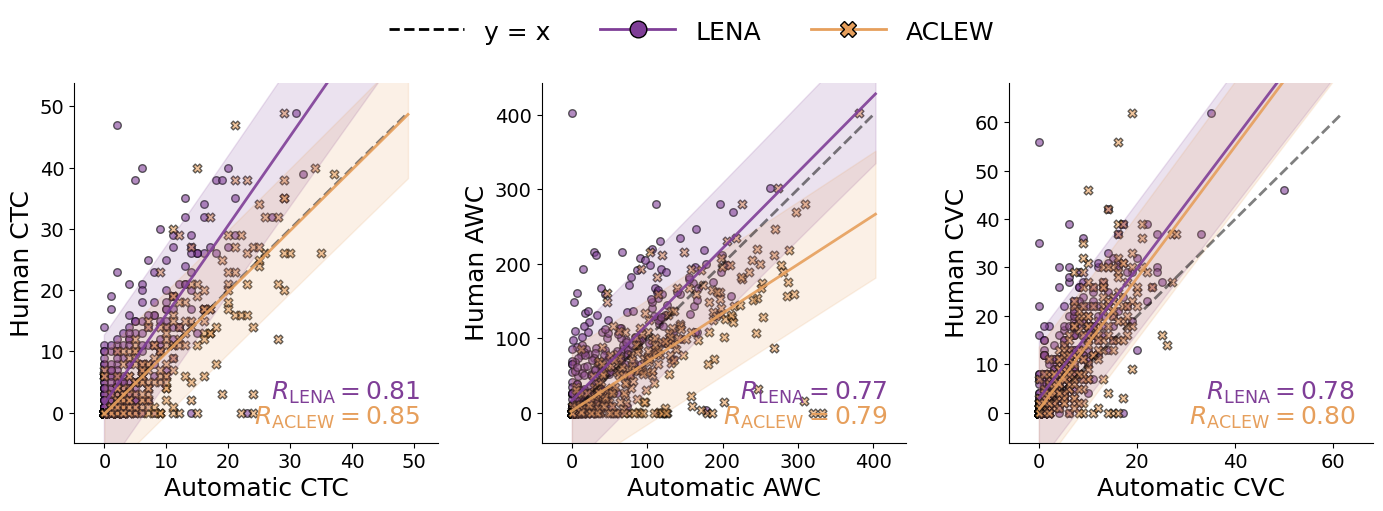

In [10]:
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.lines import Line2D
import numpy as np
from scipy import stats

matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.serif'] = 'Arial'
matplotlib.rcParams.update({'font.size': 18, 'legend.handleheight': 1, 'hatch.linewidth': 1.0,
                          'lines.markersize': 6, 'lines.linewidth': 2, 'errorbar.capsize': 5,
                           'xtick.labelsize':14, 'ytick.labelsize':14, 'axes.labelsize': 18})

cm = 1/2.54
lena_color = '#7F3E97'
aclew_color = '#E69F5C'

def add_regression_plot(ax, lena_x, aclew_x, human_y):
    """Add scatter plots and regression lines with confidence intervals.
    Args:
        lena_x, aclew_x: predictor variables (automatic measures)
        human_y: target variable to predict (human measures)
    """
    # Get common range for both x and y
    min_val = min(lena_x.min(), aclew_x.min(), human_y.min())
    max_val = max(lena_x.max(), aclew_x.max(), human_y.max())
    
    # Create range for regression lines
    plot_range = np.linspace(min_val, max_val, 100)
    
    # Add y=x line first
    ax.plot(plot_range, plot_range, 'k--', alpha=0.5, label='y = x')
    
    def calc_regression(x, y, color):
        slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
        y_pred = slope * plot_range + intercept
        
        # Calculate prediction interval
        y_hat = slope * x + intercept
        mse = np.sum((y - y_hat) ** 2) / (len(x) - 2)
        x_mean = np.mean(x)
        x_std = np.sum((x - x_mean) ** 2)
        t = stats.t.ppf(0.975, len(x) - 2)
        pi = t * np.sqrt(mse * (1 + 1/len(x) + (plot_range - x_mean)**2 / x_std))
        
        ax.plot(plot_range, y_pred, color=color, alpha=0.9)
        ax.fill_between(plot_range, y_pred - pi, y_pred + pi, color=color, alpha=0.15)
        
        return r_value
    
    # Plot scatter points
    ax.scatter(lena_x, human_y, color=lena_color, alpha=0.6, s=30, edgecolor='black', label='LENA')
    ax.scatter(aclew_x, human_y, color=aclew_color, alpha=0.6, edgecolor='black', marker='X', s=40, label='ACLEW')
    
    # Calculate regression for both datasets
    lena_r = calc_regression(lena_x, human_y, lena_color)
    aclew_r = calc_regression(aclew_x, human_y, aclew_color)
    
    # Set same limits for both axes
    dist = max_val - min_val
    min_val = min_val - 0.1 * dist
    max_val = max_val + 0.1 * dist
    ax.set_xlim(min_val, max_val)
    ax.set_ylim(min_val, max_val)
    
    # Add R values as text annotations
    ax.text(0.95, 0.12, f'$R_{{\\mathrm{{LENA}}}} = {lena_r:.2f}$', 
            transform=ax.transAxes, color=lena_color,
            fontweight='bold', horizontalalignment='right')
    
    ax.text(0.95, 0.05, f'$R_{{\\mathrm{{ACLEW}}}} = {aclew_r:.2f}$', 
            transform=ax.transAxes, color=aclew_color, 
            fontweight='bold', horizontalalignment='right')
    
    return lena_r, aclew_r

def plot_measures_scatter(lena_measures, aclew_measures, human_measures, measures):
    """Plot scatter plots with regression lines for each measure using all data points."""
    n_measures = len(measures)
    fig_width = 12 * n_measures
    fig, axes = plt.subplots(1, n_measures, figsize=(fig_width*cm, 12*cm))
    
    if n_measures == 1:
        axes = [axes]
    
    for i, (ax, measure) in enumerate(zip(axes, measures)):
        # Plot regression and get R values using all data points
        lena_r, aclew_r = add_regression_plot(ax,
                                            lena_measures[measure],  # predictor (x)
                                            aclew_measures[measure], # predictor (x)
                                            human_measures[measure]) # target (y)
        
        ax.set_xlabel(f'Automatic {measure_name[measure]}')  # predictor on x-axis
        ax.set_ylabel(f'Human {measure_name[measure]}')      # target on y-axis
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        
    # Create a single legend for all subplots
    legend_elements = [
        Line2D([0], [0], color='black', linestyle='--', label='y = x', lw=2),  # y=x dashed line
        Line2D([0], [0], color=lena_color, marker='o', label='LENA', lw=2, 
               markersize=12, markerfacecolor=lena_color, markeredgecolor='black'),
        Line2D([0], [0], color=aclew_color, marker='X', label='ACLEW', lw=2, 
               markersize=12, markerfacecolor=aclew_color, markeredgecolor='black')
    ]

    # Add legend to the figure
    fig.legend(handles=legend_elements, ncol=3, bbox_to_anchor=(0.5, 1.05), 
               loc='center', frameon=False, handlelength=3)
        
    plt.tight_layout()
    return fig, axes

# Usage example:
measures_to_compare = ['5s_CTC', 'wc_adu', 'CVC']

fig, axes = plot_measures_scatter(lena_measures, aclew_measures, human_measures, 
                                measures_to_compare)
plt.savefig('/home/engaclew/neurogen/figures/2mn/measures_pearson_scatter.png', dpi=300, bbox_inches='tight')
plt.show()

{'5s_CTC': 'CTC', 'wc_adu': 'AWC', 'CVC': 'CVC'}
CVC


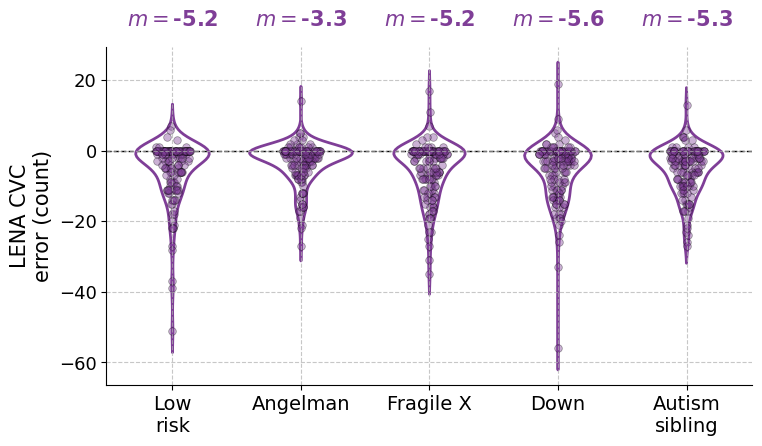

{'5s_CTC': 'CTC', 'wc_adu': 'AWC', 'CVC': 'CVC'}
CVC


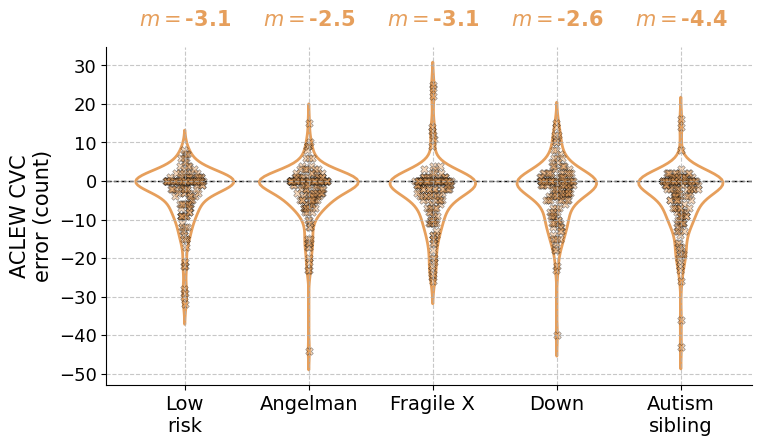

{'5s_CTC': 'CTC', 'wc_adu': 'AWC', 'CVC': 'CVC'}
CVC


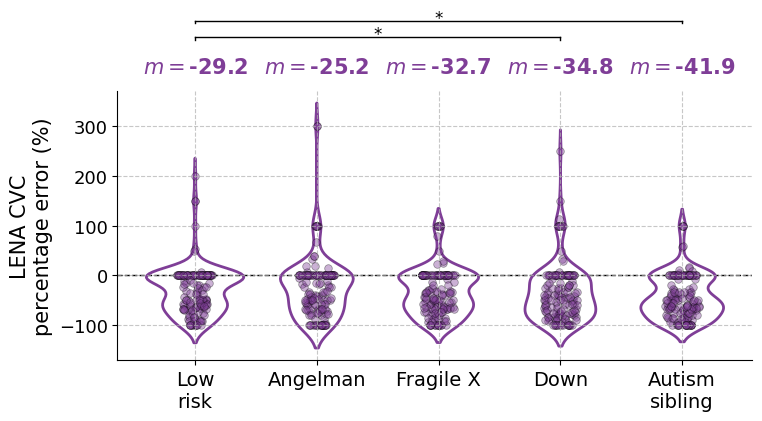

{'5s_CTC': 'CTC', 'wc_adu': 'AWC', 'CVC': 'CVC'}
CVC


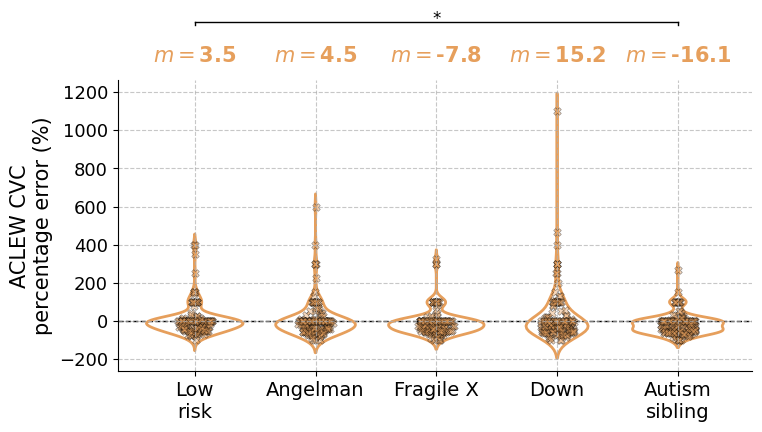

{'5s_CTC': 'CTC', 'wc_adu': 'AWC', 'CVC': 'CVC'}
5s_CTC


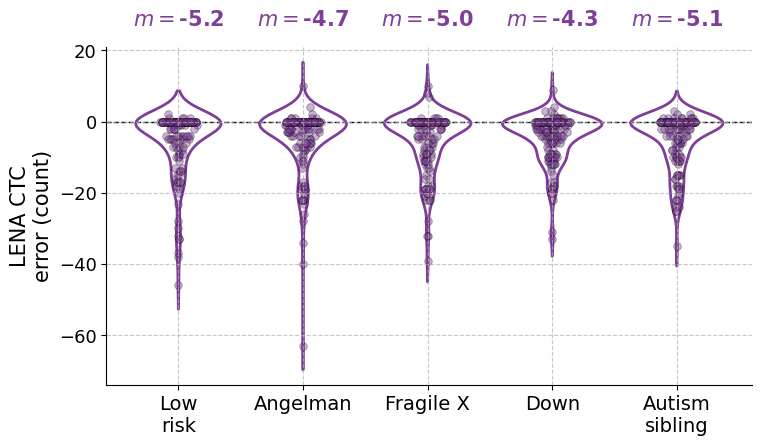

{'5s_CTC': 'CTC', 'wc_adu': 'AWC', 'CVC': 'CVC'}
5s_CTC


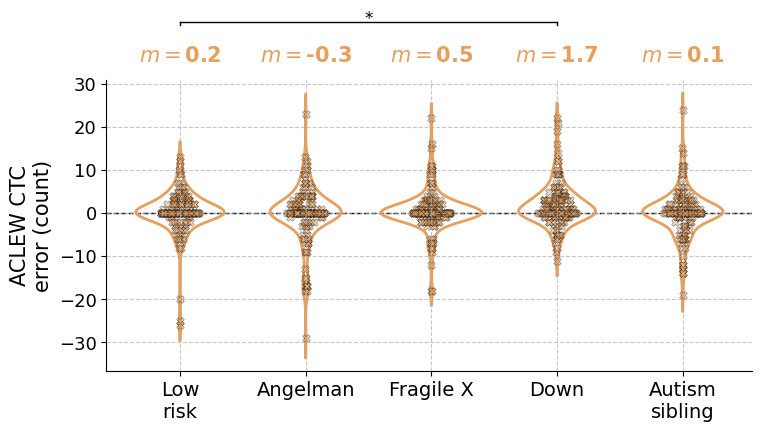

{'5s_CTC': 'CTC', 'wc_adu': 'AWC', 'CVC': 'CVC'}
5s_CTC


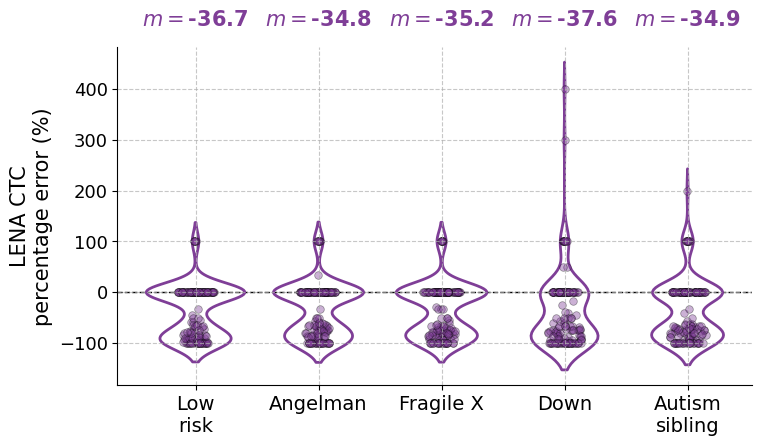

{'5s_CTC': 'CTC', 'wc_adu': 'AWC', 'CVC': 'CVC'}
5s_CTC


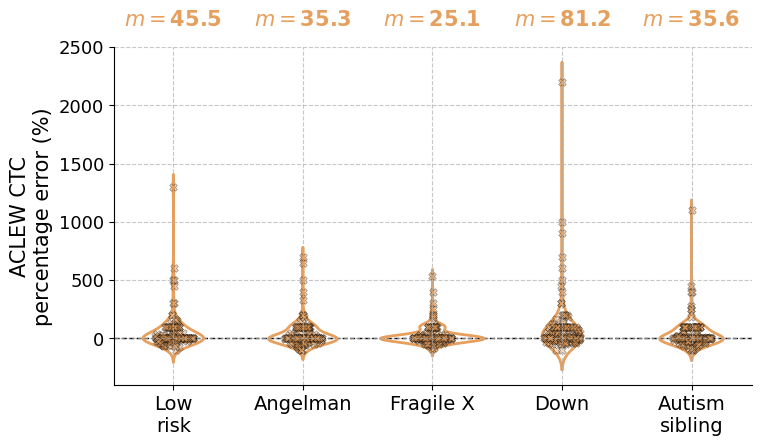

{'5s_CTC': 'CTC', 'wc_adu': 'AWC', 'CVC': 'CVC'}
wc_adu


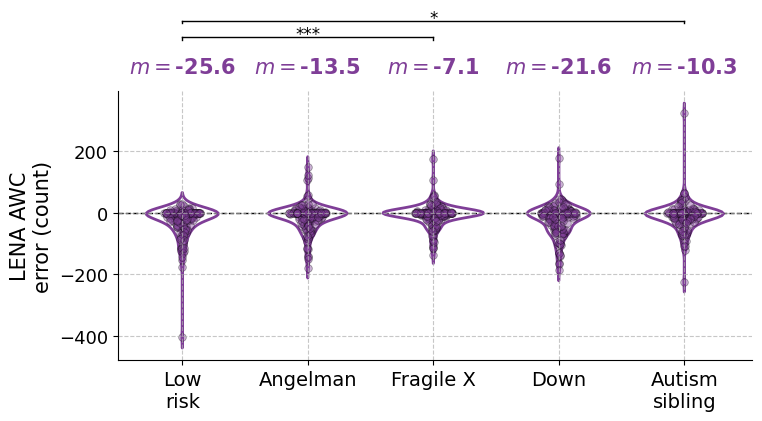

{'5s_CTC': 'CTC', 'wc_adu': 'AWC', 'CVC': 'CVC'}
wc_adu


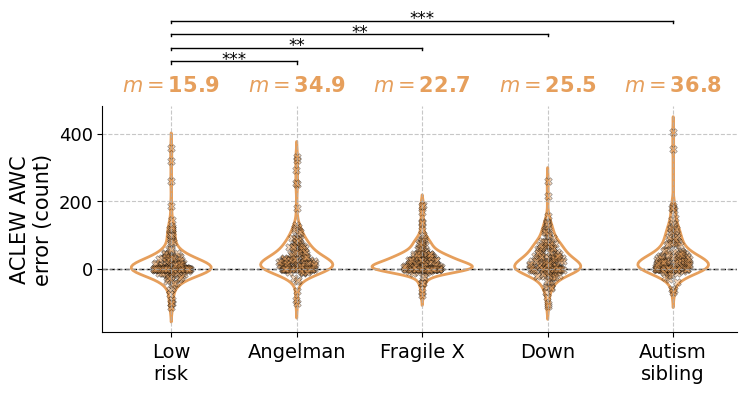

{'5s_CTC': 'CTC', 'wc_adu': 'AWC', 'CVC': 'CVC'}
wc_adu


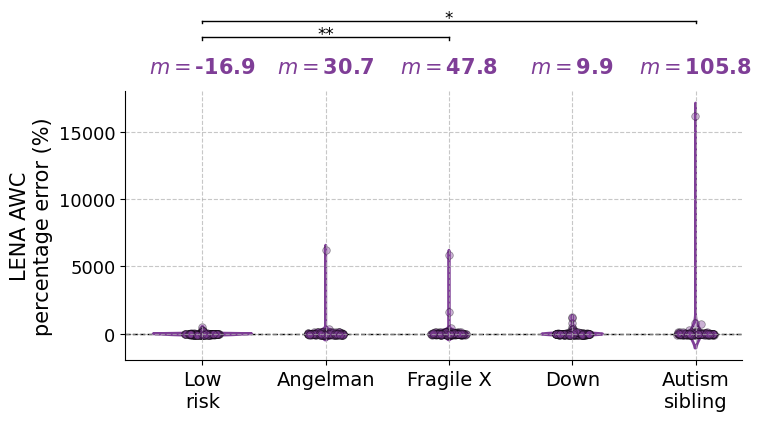

In [ ]:
# Group-level performance metrics for CTC, AWC, and CVC measures
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.patheffects as path_effects
from scipy import stats
import seaborn as sns


matplotlib.rcParams.update({'font.size': 15, 'legend.handleheight': 1, 'hatch.linewidth': 1.0,
                          'lines.markersize': 10, 'lines.linewidth': 2, 'errorbar.capsize': 5,
                           'xtick.labelsize': 14, 'ytick.labelsize': 13})
def add_group_significance_bars(ax, df, groups, col):
    def get_stars(p_value):
        if p_value < 0.001:
            return '***'
        elif p_value < 0.01:
            return '**'
        elif p_value < 0.05:
            return '*'
        return ''
    
    # Get y-axis range
    ymin, ymax = ax.get_ylim()
    ydist = ymax - ymin
    
    # Calculate relative spacings
    stars_spacing = 0.01 * ydist
    bar_spacing = 0.06 * ydist
    tick_height = 0.01 * ydist
    base_height = ymax + (0.2 * ydist)
    
    # Perform statistical tests against low_risk group
    control_group = 'low_risk'
    control_data = df[df['group_id'] == control_group][col]
    
    sig_count = 0
    has_sig_res = False
    
    # Compare each group against control
    for i, group in enumerate(groups[1:], 1):  # Skip control group
        group_data = df[df['group_id'] == group][col]
        if len(group_data) == 0:  # Skip if no data for this group
            continue
            
        # Perform Mann-Whitney U test
        statistic, p_value = stats.mannwhitneyu(
            control_data, 
            group_data,
            alternative='two-sided'
        )
        
        # Add significance bars if result is significant
        stars = get_stars(p_value)
        if stars:
            has_sig_res = True
            current_height = base_height + (sig_count * bar_spacing)
            sig_count += 1
            
            # Draw the bar and ticks
            ax.plot([0, i], [current_height, current_height],
                   'k-', linewidth=1, clip_on=False)
            ax.plot([0, 0], [current_height - tick_height, current_height],
                   'k-', linewidth=1, clip_on=False)
            ax.plot([i, i], [current_height - tick_height, current_height],
                   'k-', linewidth=1, clip_on=False)
            
            # Add stars
            ax.text((0 + i) / 2, current_height + stars_spacing,
                   stars, ha='center', va='center', 
                   fontsize=12, clip_on=False)
    
    ax.set_ylim(ymin, ymax)

def plot_metric_by_groups(scores, algorithm='LENA', measure='5s_CTC', metric='me'):
    # Define label mapping with desired order
    label_name = {
        'low_risk': 'Low\nrisk',
        'angelman_syndrome': 'Angelman',
        'fragile_x_syndrome': 'Fragile X',
        'down_syndrome': 'Down',
        'autism_sibling': 'Autism\nsibling'
    }
    
    # Use ordered list of groups
    groups = list(label_name.keys())
    
    def get_x_position(y_val, kde, center_x, max_width=0.15):
        density = kde(y_val)[0]
        max_density = kde(kde.dataset).max()
        width = max_width * (density / max_density)
        return center_x + np.random.uniform(-width, width)
    
    # Style parameters
    color = '#7F3E97' if algorithm == 'LENA' else '#E69F5C'
    marker = 'o' if algorithm == 'LENA' else 'X'
    marker_size = 30
    alpha = .4
    cm = 1/2.54
    
    # Create figure
    fig, ax = plt.subplots(1, 1, figsize=(20*cm, 12*cm))
    
    # Create plot data
    plot_data = []
    for group_id in groups:
        mask = scores['group_id'] == group_id
        values = scores[measure][f'{metric}_list'][mask]
        plot_data.extend([{
            'group_id': group_id,
            'group_label': label_name[group_id],
            'error': val
        } for val in values])
    
    df = pd.DataFrame(plot_data)
    
    # Create violin plot
    violin_parts = sns.violinplot(data=df, x='group_label', y='error',
                                ax=ax, color='white',
                                inner=None, linewidth=2)
    
    for pc in violin_parts.collections:
        pc.set_facecolor('none')
        pc.set_edgecolor(color)
    
    # Add scatter points
    for i, group_id in enumerate(groups):
        group_data = df[df['group_id'] == group_id]['error']
        if len(group_data) > 0:
            kde = stats.gaussian_kde(group_data)
            for y_val in group_data:
                x_pos = i + get_x_position(y_val, kde, 0)
                ax.scatter(x_pos, y_val, 
                         color=color,
                         edgecolor='black',
                         s=marker_size,
                         marker=marker,
                         alpha=alpha,
                         linewidth=0.5)
            
            # Add mean value
            mean_val = group_data.mean()
            ymin, ymax = ax.get_ylim()
            ax.text(i, ymax + 0.05*(ymax - ymin), 
                   r'$m = $' + f'{mean_val:.1f}',
                   ha='center', va='bottom', 
                   color=color, weight='bold')
    
    # Add styling
    metric_labels = {
        'me': 'error',
        'mpe': 'percentage error (%)',
    }
    measure_labels = {
        '5s_CTC': 'CTC',
        'wc_adu': 'AWC',
        'CVC': 'CVC'
    }
    ylabel = f'{algorithm} {measure_labels[measure]}\n{metric_labels[metric]}'
    if metric == 'me' and measure == 'voc_dur_chi':
        ylabel += ' (s)'
    elif metric == 'me':
        ylabel += ' (count)'
    print(measure_labels)
    print(measure)
    ax.axhline(0, color='black', linestyle='--', linewidth=1, zorder=0)
    ax.set_ylabel(ylabel)
    ax.set_xlabel('')
    ax.grid(True, linestyle='--', alpha=0.7, zorder=0)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Add significance bars and adjust layout
    add_group_significance_bars(ax, df, groups, 'error')
    plt.tight_layout()
    
    return fig, ax

for measure in ['CVC', '5s_CTC', 'wc_adu']:
    for metric in ['me', 'mpe']:
        fig, ax = plot_metric_by_groups(lena_scores, algorithm='LENA', measure=measure, metric=metric)
        plt.savefig(f'/home/engaclew/neurogen/figures/2mn_group/group_{metric}_lena_{measure}.png', dpi=300)
        plt.show()

        fig, ax = plot_metric_by_groups(aclew_scores, algorithm='ACLEW', measure=measure, metric=metric)
        plt.savefig(f'/home/engaclew/neurogen/figures/2mn_group/group_{metric}_aclew_{measure}.png', dpi=300)
        plt.show()

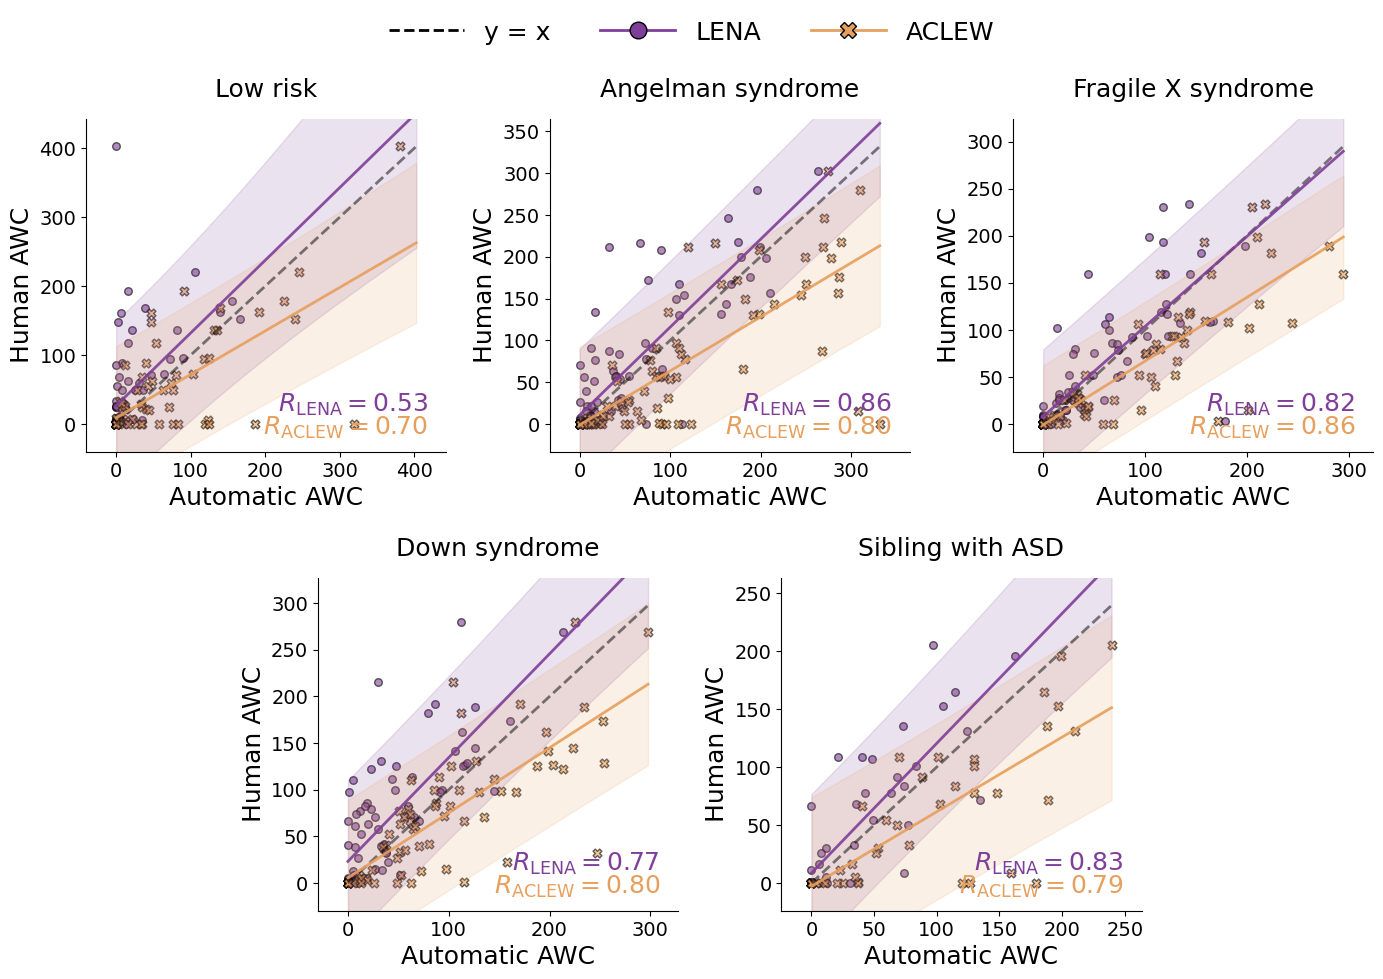

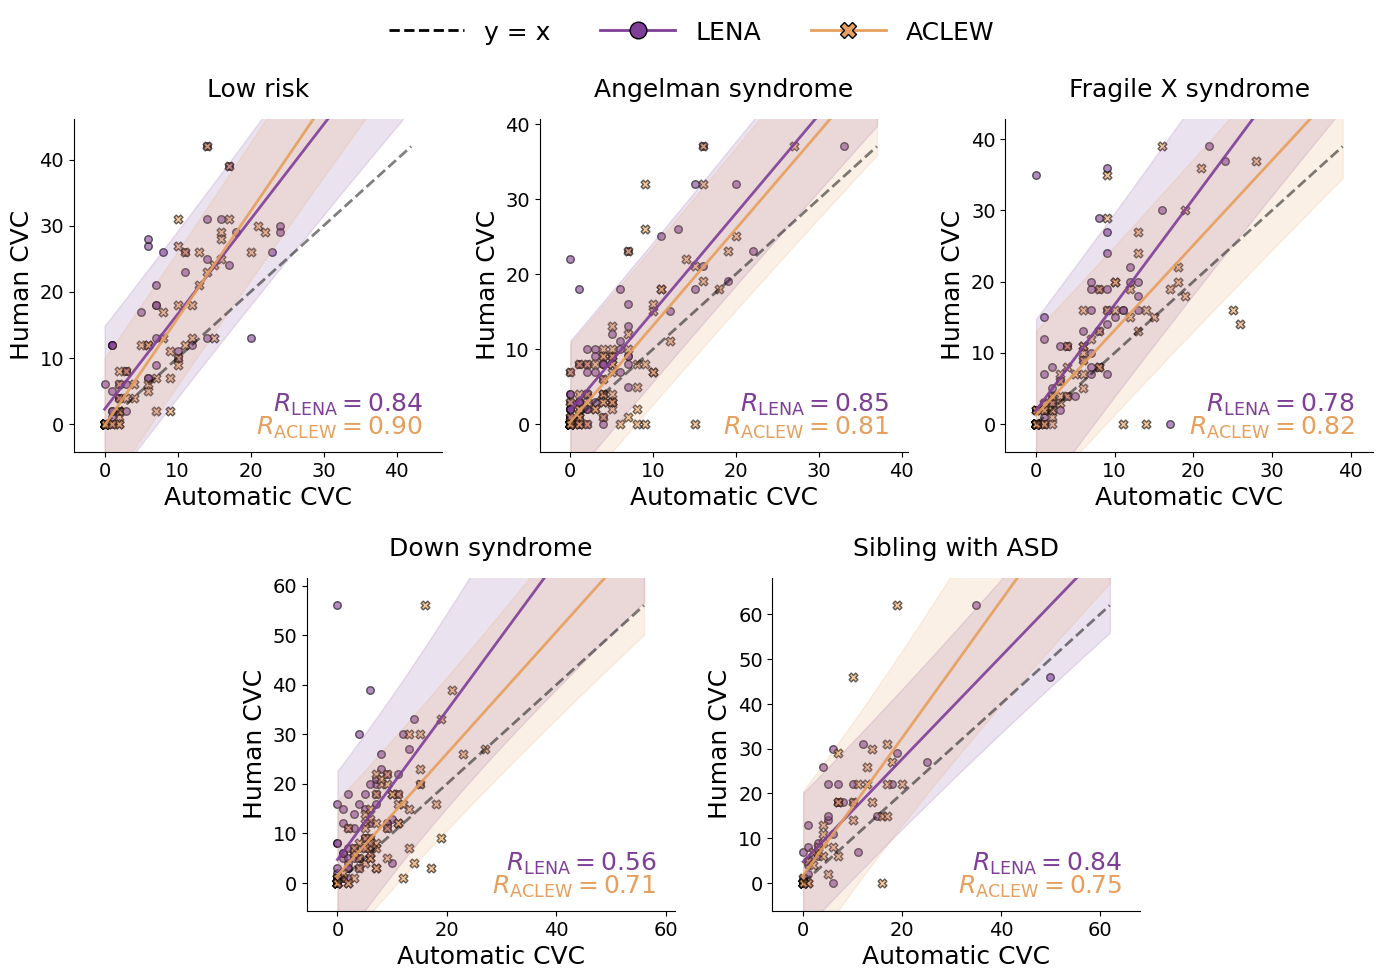

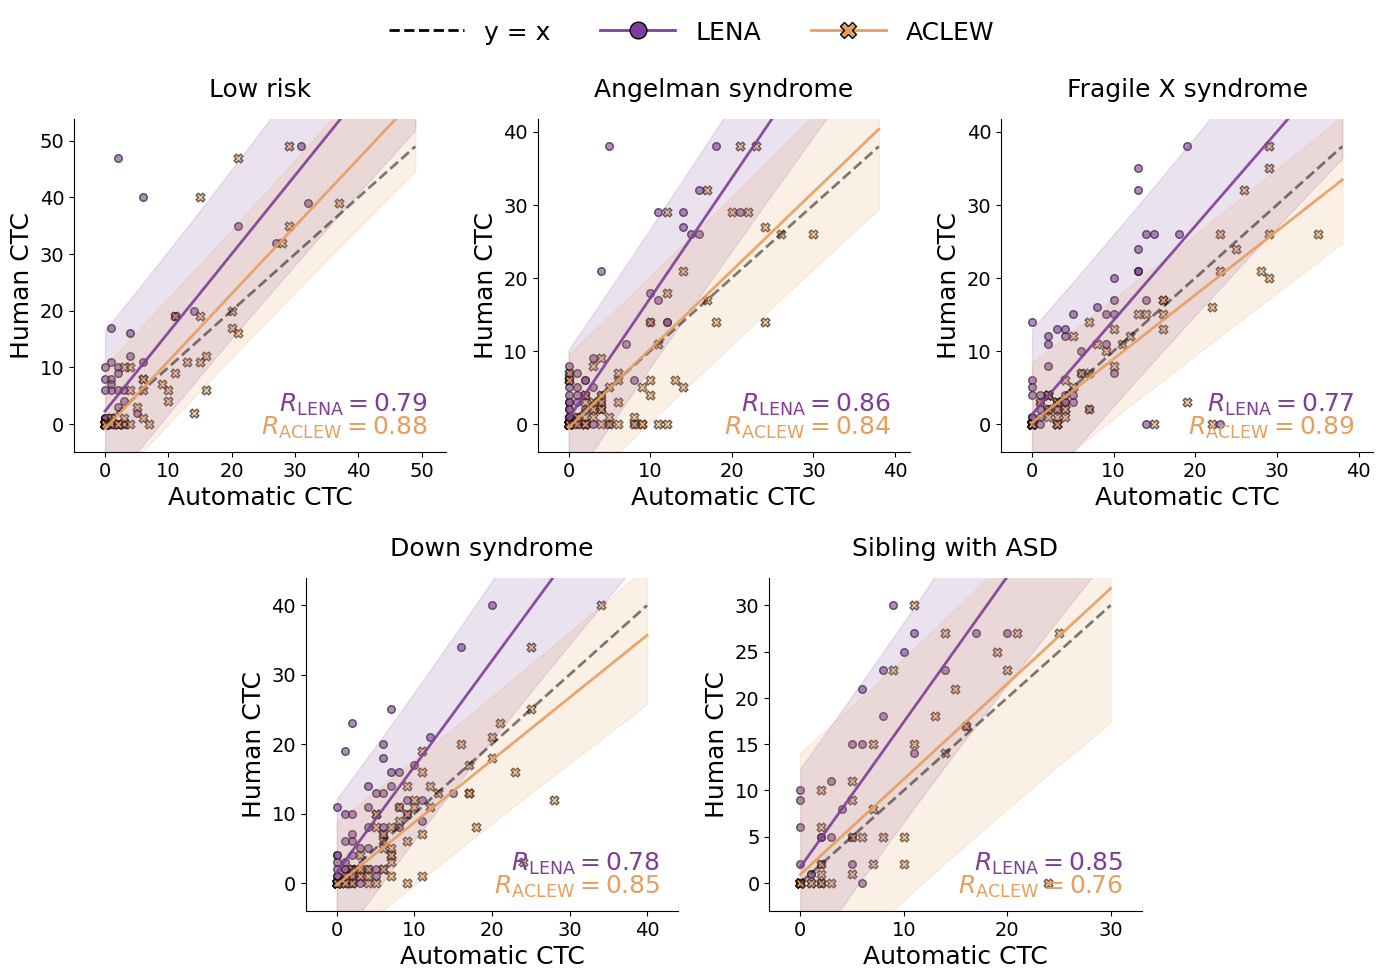

In [11]:
def plot_measure_by_group_irregular(lena_measures, aclew_measures, human_measures, measure):
    """Plot scatter plots with regression lines for a single measure across groups.
    First row has 3 plots, second row has 2 centered plots."""
    
    # Define group labels (also defines the order)
    group_labels = {
        'low_risk': 'Low risk',
        'angelman_syndrome': 'Angelman syndrome',
        'fragile_x_syndrome': 'Fragile X syndrome',
        'down_syndrome': 'Down syndrome',
        'autism_sibling': 'Sibling with ASD'
    }
    
    # Create figure with irregular grid
    fig = plt.figure(figsize=(36*cm, 24*cm))
    gs = fig.add_gridspec(2, 6, height_ratios=[1, 1])
    
    # Create axes - 3 on top, 2 centered on bottom
    axes = []
    # Top row - 3 plots
    for i in range(3):
        ax = fig.add_subplot(gs[0, i*2:i*2+2])
        axes.append(ax)
    # Bottom row - 2 plots centered
    for i in range(2):
        ax = fig.add_subplot(gs[1, i*2+1:i*2+3])
        axes.append(ax)
        
    for ax, group_key in zip(axes, group_labels.keys()):
        # Filter data for this group
        group_mask = human_measures['group_id'] == group_key
        lena_group = lena_measures[group_mask]
        aclew_group = aclew_measures[group_mask]
        human_group = human_measures[group_mask]
        
        # Plot regression and get R values
        lena_r, aclew_r = add_regression_plot(ax,
                                            lena_group[measure],
                                            aclew_group[measure],
                                            human_group[measure])
        
        # Set labels
        ax.set_xlabel(f'Automatic {measure_name[measure]}')
        ax.set_ylabel(f'Human {measure_name[measure]}')
        
        # Add group label
        ax.text(0.5, 1.05, group_labels[group_key],
               transform=ax.transAxes,
               ha='center',
               va='bottom')
        
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
    
    # Create legend
    legend_elements = [
        Line2D([0], [0], color='black', linestyle='--', label='y = x', lw=2),
        Line2D([0], [0], color=lena_color, marker='o', label='LENA', lw=2,
               markersize=12, markerfacecolor=lena_color, markeredgecolor='black'),
        Line2D([0], [0], color=aclew_color, marker='X', label='ACLEW', lw=2,
               markersize=12, markerfacecolor=aclew_color, markeredgecolor='black')
    ]
    
    # Add legend to the figure
    fig.legend(handles=legend_elements, ncol=3, bbox_to_anchor=(0.5, 1.02),
               loc='center', frameon=False, handlelength=3)
    
    plt.tight_layout()
    return fig, axes

# Usage
measure_to_plot = 'wc_adu'
fig, axes = plot_measure_by_group_irregular(lena_measures, aclew_measures, human_measures, 
                                          measure_to_plot)
plt.savefig('/home/engaclew/neurogen/figures/2mn_group/group_pearson_lena_vtc_awc.png', dpi=300)
plt.show()

measure_to_plot = 'CVC'  # or 'wc_adu' or 'CVC'
fig, axes = plot_measure_by_group_irregular(lena_measures, aclew_measures, human_measures, 
                                          measure_to_plot)
plt.savefig('/home/engaclew/neurogen/figures/2mn_group/group_pearson_lena_vtc_cvc.png', dpi=300)
plt.show()

measure_to_plot = '5s_CTC'  # or 'wc_adu' or 'CVC'
fig, axes = plot_measure_by_group_irregular(lena_measures, aclew_measures, human_measures, 
                                          measure_to_plot)
plt.savefig('/home/engaclew/neurogen/figures/2mn_group/group_pearson_lena_vtc_ctc.png', dpi=300)
plt.show()

In [31]:
print(human_measures)

               recording_filename  segment_onset  segment_offset  child_id  \
0    20190828_145547_024884_2.wav       28611000        28731000      5061   
1    20211022_110857_045737_2.wav       49860000        49980000      6161   
2    20221129_154915_045733_1.wav        2072000         2192000      6641   
3      20210318_114509_043298.wav       18264000        18384000      5961   
4    20211103_114626_022870_1.wav        7296000         7416000      6382   
..                            ...            ...             ...       ...   
379  20221129_154915_045733_1.wav       39778000        39898000      6641   
380  20230208_103250_043299_1.wav       49225000        49345000      7261   
381  20230321_124603_024879_1.wav       36581000        36701000      7291   
382  20210624_093317_024883_2.wav        1639000         1759000      5851   
383  20210624_093317_024883_2.wav       14868000        14988000      5851   

     duration_eaf/an1  voc_dur_chi  voc_chi  wc_fem  wc_mal  wc

In [45]:
cum_voc_dur_human = human_measures.groupby('group_id')['voc_dur_chi'].mean()
print(cum_voc_dur_human)

group_id
angelman_syndrome      5423.949495
autism_sibling        10838.733333
down_syndrome          7099.426667
fragile_x_syndrome     7602.211111
low_risk              10467.653333
Name: voc_dur_chi, dtype: float64


/tmp/ipykernel_37133/950160201.py:59: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b-X" (-> color='b'). The keyword argument will take precedence.
  ax.plot(x_axis, y1,
/tmp/ipykernel_37133/950160201.py:61: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r-o" (-> color='r'). The keyword argument will take precedence.
  ax.plot(x_axis, y2,


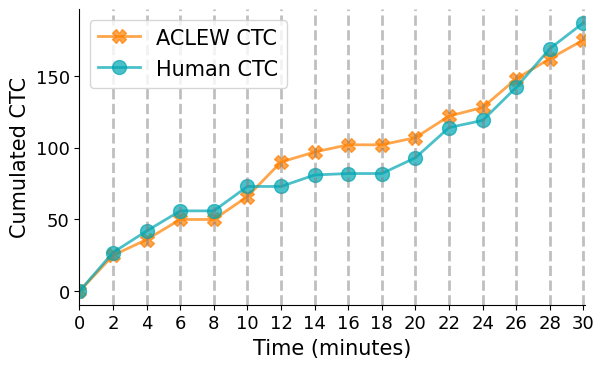

In [51]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib

matplotlib.rcParams.update({'font.size': 15, 'legend.handleheight': 1, 'hatch.linewidth': 1.0,
                          'lines.markersize': 10, 'lines.linewidth': 2, 'errorbar.capsize': 5,
                           'xtick.labelsize': 13, 'ytick.labelsize': 13})

def plot_measures_over_time(aclew_df, human_df, recording_id, measure, title=None):
    """
    Plot a measure from both dataframes for a single recording, sorted by onset time.
    
    Parameters:
    -----------
    aclew_df : pandas.DataFrame
        The ACLEW dataframe
    human_df : pandas.DataFrame
        The human measures dataframe
    recording_id : str
        The recording filename to plot
    measure : str
        The measure to plot (e.g., 'CVC', '5s_CTC', 'wc_adu')
    title : str, optional
        Custom title for the plot
    figsize : tuple, optional
        Figure size (width, height)
        
    Returns:
    --------
    matplotlib.figure.Figure
        The generated figure
    """
    measure_name = {'5s_CTC': 'CTC',
                    'CVC': 'CVC',
                    'wc_adu': 'AWC'}
    
    # Filter data for the specified recording
    aclew_recording = aclew_df[aclew_df['recording_filename'] == recording_id].copy()
    human_recording = human_df[human_df['recording_filename'] == recording_id].copy()
    

    # Create figure
    cm = 1/2.54
    fig, ax = plt.subplots(figsize=(16*cm, 10*cm))


    x_axis = (aclew_recording['segment_offset'] - aclew_recording['segment_onset']) / 60000 
    x_axis = x_axis.cumsum().tolist()

    aclew_recording = aclew_recording.sort_values('segment_onset')
    human_recording = human_recording.sort_values('segment_onset')
    y1 = aclew_recording['cumulative'] = aclew_recording[measure].cumsum().tolist()
    y2 = human_recording['cumulative'] = human_recording[measure].cumsum().tolist()

    x_axis = [0] + x_axis
    y1 = [0] + y1
    y2 = [0] + y2
    ax.plot(x_axis, y1, 
            'b-X', label=f'ACLEW {measure_name[measure]}', alpha=0.7, color='#FF7F00')
    ax.plot(x_axis, y2, 
            'r-o', label=f'Human {measure_name[measure]}', alpha=0.7, color='#00A6B2')
    
    # Add vertical dashed lines every 2 minutes
    for t in range(2, 32, 2):
        ax.axvline(x=t, color='gray', linestyle='--', alpha=0.5)
    
    # Set x-axis ticks every 2 minutes up to 30 minutes
    ax.set_xticks(np.arange(0, 32, 2))
    ax.set_xlim(0, 30.1)
    
    # Add labels and title
    ax.set_xlabel('Time (minutes)')
    ax.set_ylabel(f'Cumulated {measure_name[measure]}')

    ax.legend()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.tight_layout()
    return fig

fig = plot_measures_over_time(aclew_measures, human_measures, '20230405_090552_045738_2.wav', '5s_CTC')
plt.savefig('/home/engaclew/neurogen/figures/overunder.png', dpi=300, bbox_inches='tight')
plt.show()
# Example usage:
#for recording_filename in aclew_measures['recording_filename'].unique():
#    print(recording_filename)
#    fig = plot_measures_over_time(aclew_measures, human_measures, recording_filename, '5s_CTC')
#    plt.show()

In [33]:
tt = human_measures.groupby('recording_filename').agg({'5s_CTC':np.sum})
tt

/tmp/ipykernel_37133/2976894366.py:1: FutureWarning: The provided callable <function sum at 0x7ec0444d44c0> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  tt = human_measures.groupby('recording_filename').agg({'5s_CTC':np.sum})


,5s_CTC
recording_filename,
20180808_111213_024881.wav,13
20180809_181624_025481.wav,201
20180906_131431_024882.wav,85
20181218_132113_024879.wav,141
20190307_091344_022872.wav,66
20190618_135122_024883.wav,104
20190828_145547_024884_2.wav,201
20201104_094551_024882_1.wav,190
20210127_103244_024879_1.wav,20
